**ESSENTIAL LIBRARIES**

In [1]:
from google.colab import files
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import FunctionTransformer
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


**DATASET UPLOADING**

In [2]:


# This will open a file dialog to upload your file
uploaded = files.upload()

# Step 3: Load the Dataset
import pandas as pd

# Assuming the uploaded file is named "CSAW-CC_breast_cancer_screening_data.csv"
file_name = "CSAW-CC_breast_cancer_screening_data.csv"
df = pd.read_csv(file_name)

# Display the first few rows to confirm successful upload
print("Dataset Loaded Successfully")
df.head()

Saving CSAW-CC_breast_cancer_screening_data.csv to CSAW-CC_breast_cancer_screening_data.csv
Dataset Loaded Successfully


,anon_patientid,exam_year,anon_filename,x_age,x_case,x_cancer_laterality,x_type,x_lymphnode_met,rad_timing,rad_r1,rad_r2,rad_recall,rad_recall_type_right,rad_recall_type_left,imagelaterality,viewposition,libra_breastarea,libra_densearea,libra_percentdensity
0,2,2015,00002_20990909_L_CC_1.dcm,1,1,Left,3.0,0.0,2.0,0.0,0.0,0.0,NaN,NaN,Left,CC,127.25809,29.595217,23.256058
1,2,2015,00002_20990909_L_MLO_1.dcm,1,1,Left,3.0,0.0,2.0,0.0,0.0,0.0,NaN,NaN,Left,MLO,122.31812,39.298000,32.127705
2,2,2015,00002_20990909_R_CC_1.dcm,1,1,Left,3.0,0.0,2.0,0.0,0.0,0.0,NaN,NaN,Right,CC,114.57063,23.637600,20.631468
3,2,2015,00002_20990909_R_MLO_1.dcm,1,1,Left,3.0,0.0,2.0,0.0,0.0,0.0,NaN,NaN,Right,MLO,133.20238,36.162785,27.148750
4,4,2012,00004_20990909_R_CC_1.dcm,1,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,Right,CC,201.18773,68.998276,34.295467


**DATA OVERVIEW AND PRE-PROCESSING**

In [3]:
# Step 1: Check for Missing Data
print("Missing Data Summary:")
print(df.isnull().sum())

# Step 2: Handle Missing Values
# Example: Fill missing numerical values with the median
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# For categorical variables, fill with mode
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Step 3: Encode Categorical Data
from sklearn.preprocessing import LabelEncoder

# Encode imagelaterality (e.g., Left, Right) and viewposition (e.g., CC, MLO)
encoder = LabelEncoder()
df['imagelaterality_encoded'] = encoder.fit_transform(df['imagelaterality'])
df['viewposition_encoded'] = encoder.fit_transform(df['viewposition'])

# Step 4: Normalize Imaging Features
# Normalizing breast area and density to the range [0, 1]
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
imaging_features = ['libra_breastarea', 'libra_densearea', 'libra_percentdensity']
df[imaging_features] = scaler.fit_transform(df[imaging_features])

# Step 5: Split Data for Training and Testing
from sklearn.model_selection import train_test_split

# Define target variables for various tasks
# Binary Cancer Prediction
df['cancer_target'] = df['x_case'].astype(int)  # Assuming x_case indicates cancer presence

# Train-Test Split
X = df.drop(columns=['cancer_target', 'anon_patientid', 'anon_filename'])  # Drop unnecessary columns
y = df['cancer_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display split summary
print(f"Training Data Size: {X_train.shape}")
print(f"Testing Data Size: {X_test.shape}")


Missing Data Summary:
anon_patientid               0
exam_year                    0
anon_filename                0
x_age                        0
x_case                       0
x_cancer_laterality      91484
x_type                   91632
x_lymphnode_met          92032
rad_timing               91484
rad_r1                    7988
rad_r2                    8048
rad_recall                8016
rad_recall_type_right    97264
rad_recall_type_left     97064
imagelaterality              0
viewposition                 0
libra_breastarea             0
libra_densearea              0
libra_percentdensity         0
dtype: int64
Training Data Size: (79030, 19)
Testing Data Size: (19758, 19)


In [4]:
# Step 1: Drop Columns with Excessive Missing Data
# Threshold: Drop columns with more than 50% missing data
threshold = len(df) * 0.5
df = df.dropna(thresh=threshold, axis=1)

print("Columns Retained After Dropping High Missingness:")
print(df.columns)

# Step 2: Fill Remaining Missing Data
# Fill radiologist annotations (e.g., rad_r1, rad_r2) with median values
annotation_cols = ['rad_r1', 'rad_r2', 'rad_recall']
df[annotation_cols] = df[annotation_cols].fillna(df[annotation_cols].median())

# Check Missing Data Again
print("Remaining Missing Data After Cleaning:")
print(df.isnull().sum())


Columns Retained After Dropping High Missingness:
Index(['anon_patientid', 'exam_year', 'anon_filename', 'x_age', 'x_case',
       'x_cancer_laterality', 'x_type', 'x_lymphnode_met', 'rad_timing',
       'rad_r1', 'rad_r2', 'rad_recall', 'rad_recall_type_right',
       'rad_recall_type_left', 'imagelaterality', 'viewposition',
       'libra_breastarea', 'libra_densearea', 'libra_percentdensity',
       'imagelaterality_encoded', 'viewposition_encoded', 'cancer_target'],
      dtype='object')
Remaining Missing Data After Cleaning:
anon_patientid             0
exam_year                  0
anon_filename              0
x_age                      0
x_case                     0
x_cancer_laterality        0
x_type                     0
x_lymphnode_met            0
rad_timing                 0
rad_r1                     0
rad_r2                     0
rad_recall                 0
rad_recall_type_right      0
rad_recall_type_left       0
imagelaterality            0
viewposition               0


Number Of Cancer & Non-cancer Patients.

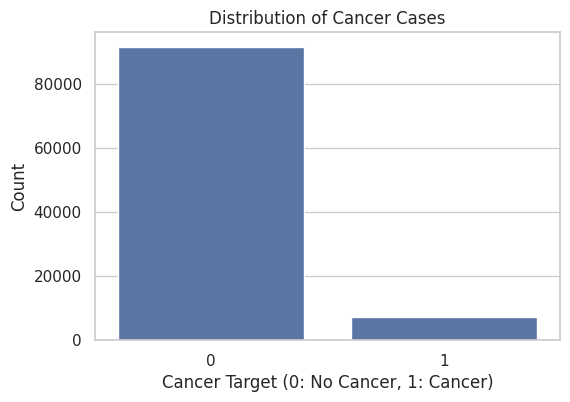

In [5]:


# Set plot style
sns.set(style="whitegrid")

# 1. Distribution of Target Variable (Cancer Cases)
plt.figure(figsize=(6, 4))
sns.countplot(x='cancer_target', data=df)
plt.title('Distribution of Cancer Cases')
plt.xlabel('Cancer Target (0: No Cancer, 1: Cancer)')
plt.ylabel('Count')
plt.show()




Breast Density Visulalization With Number Of Occurences.

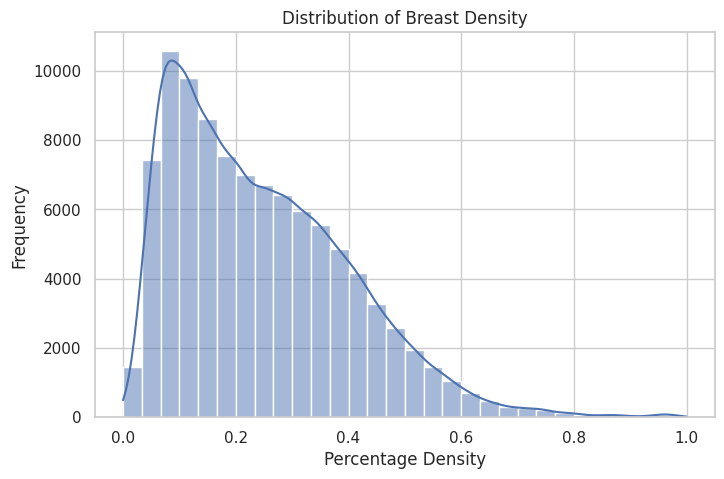

In [6]:
# 2. Breast Density Analysis
plt.figure(figsize=(8, 5))
sns.histplot(df['libra_percentdensity'], bins=30, kde=True)
plt.title('Distribution of Breast Density')
plt.xlabel('Percentage Density')
plt.ylabel('Frequency')
plt.show()



Breast Area Against Density Area For Cancerous & Non-Cancerous Breast.

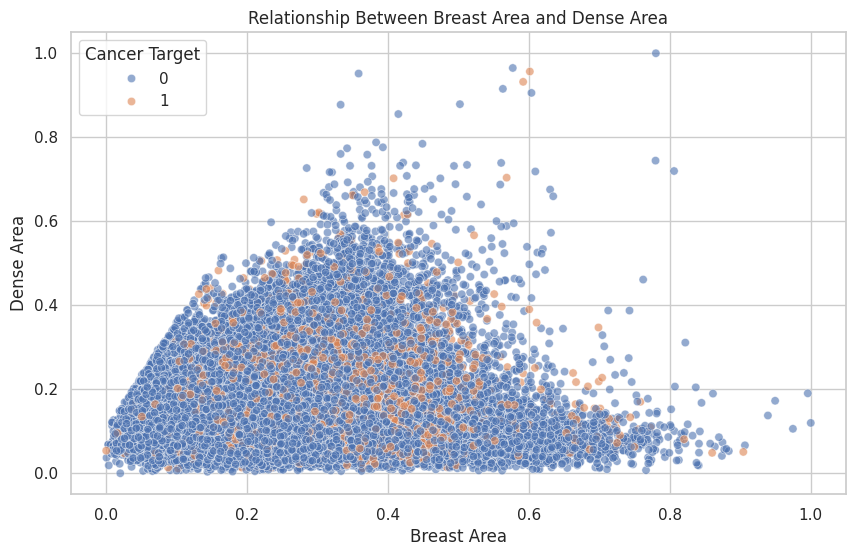

In [7]:
# 3. Imaging Feature Relationships
plt.figure(figsize=(10, 6))
sns.scatterplot(x='libra_breastarea', y='libra_densearea', hue='cancer_target', data=df, alpha=0.6)
plt.title('Relationship Between Breast Area and Dense Area')
plt.xlabel('Breast Area')
plt.ylabel('Dense Area')
plt.legend(title='Cancer Target', loc='upper left')
plt.show()



Radiologist Recall & Number Of Occurences For Cancer & Non-cancer Breast.

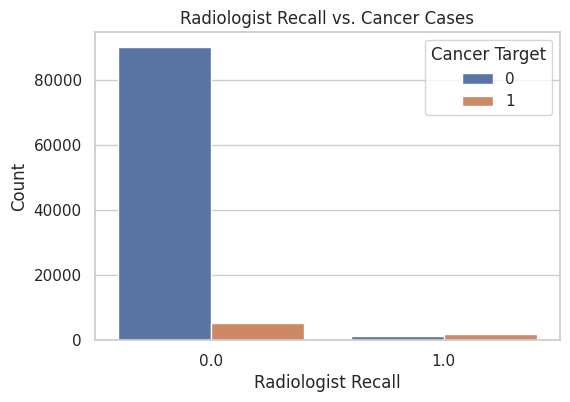

In [8]:
# 4. Radiologist Recall Analysis
plt.figure(figsize=(6, 4))
sns.countplot(x='rad_recall', hue='cancer_target', data=df)
plt.title('Radiologist Recall vs. Cancer Cases')
plt.xlabel('Radiologist Recall')
plt.ylabel('Count')
plt.legend(title='Cancer Target')
plt.show()


Heat-map For Extracting Most Features.

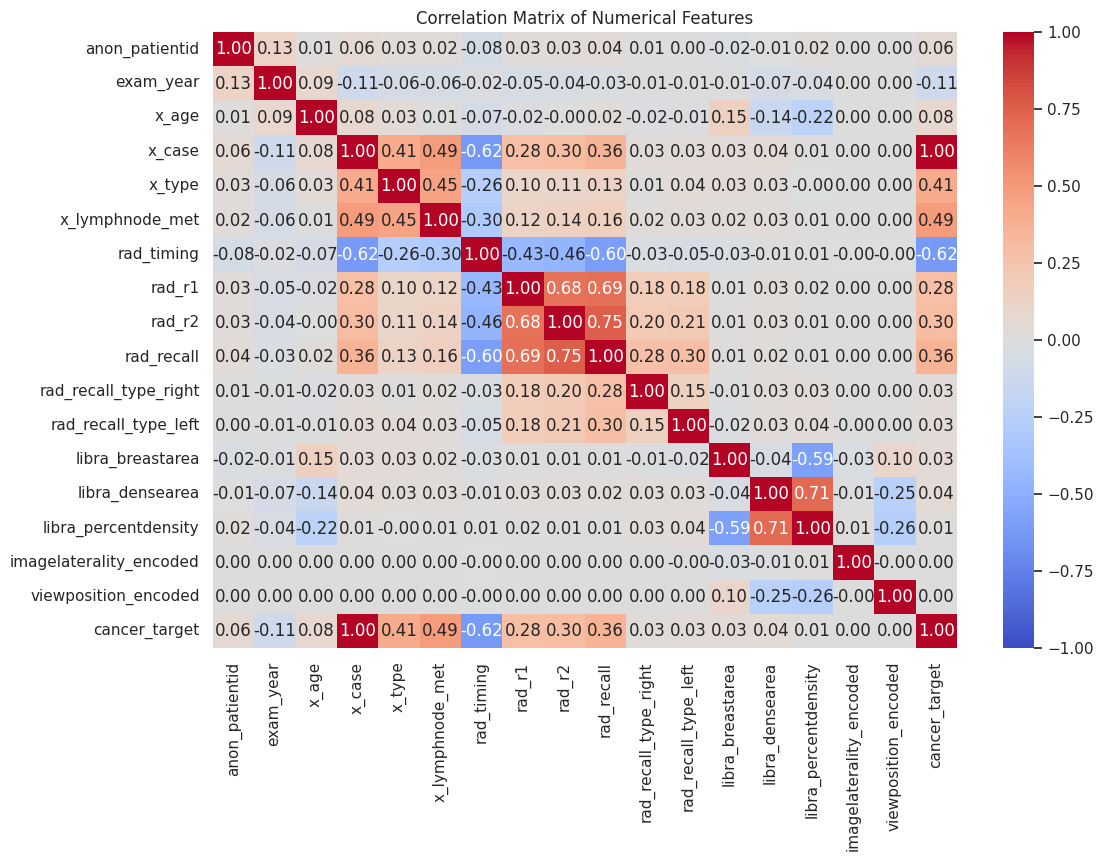

In [9]:
# Filter out non-numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


In [10]:


# Step 1: Derive New Features
# 1.1 Breast Density Ratio
df['breast_density_ratio'] = df['libra_densearea'] / (df['libra_breastarea'] + 1e-6)  # Avoid division by zero

# 1.2 Density Categories
df['density_category'] = pd.cut(
    df['libra_percentdensity'],
    bins=[-1, 25, 50, 100],
    labels=['low', 'medium', 'high']
)

# Encode density_category to numeric
df['density_category_encoded'] = df['density_category'].cat.codes

# 1.3 Interaction Features
df['rad_r1_r2_interaction'] = df['rad_r1'] * df['rad_r2']
df['rad_recall_interaction'] = df['rad_recall'] * (df['rad_r1'] + df['rad_r2'])

# Step 2: Handle Skewed Features
# Apply log transformation to imaging features
skewed_features = ['libra_breastarea', 'libra_densearea']
transformer = FunctionTransformer(np.log1p, validate=True)  # log1p for log(1 + x)
df[skewed_features] = transformer.transform(df[skewed_features])

# Step 3: Address Class Imbalance
# Split the data into features and target for balancing
X = df.drop(columns=['cancer_target', 'density_category', 'anon_patientid', 'anon_filename'])  # Drop unnecessary columns
y = df['cancer_target']

# Step 3.1: Convert all categorical features to numeric
categorical_cols = X.select_dtypes(include=['object']).columns
print("Categorical Columns:", categorical_cols)

# Use one-hot encoding for categorical variables
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Step 3.2: Apply SMOTE to balance the target classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Original Dataset Shape:", X.shape, y.value_counts())
print("Resampled Dataset Shape:", X_resampled.shape, np.bincount(y_resampled))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


Categorical Columns: Index(['x_cancer_laterality', 'imagelaterality', 'viewposition'], dtype='object')
Original Dataset Shape: (98788, 23) cancer_target
0    91484
1     7304
Name: count, dtype: int64
Resampled Dataset Shape: (182968, 23) [91484 91484]


**LOGISTIC REGRESSION MODELLING**

Logistic Regression Performance Metrics:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
AUC-ROC: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18297
           1       1.00      1.00      1.00     18297

    accuracy                           1.00     36594
   macro avg       1.00      1.00      1.00     36594
weighted avg       1.00      1.00      1.00     36594



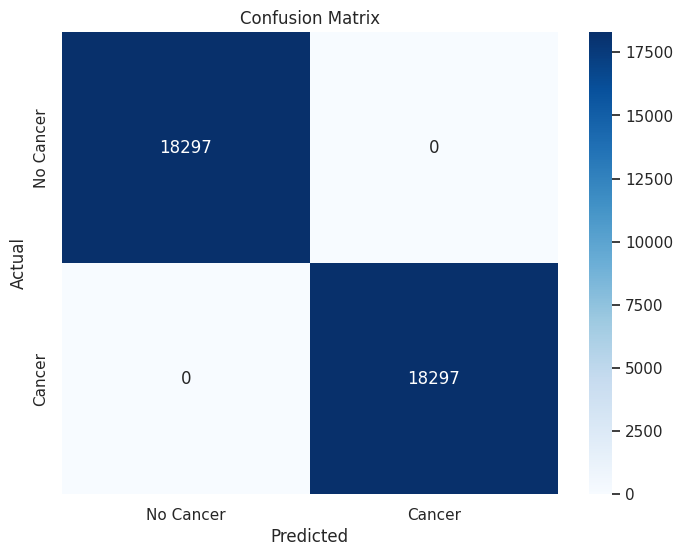

In [11]:


# Step 1: Train-Test Split on Resampled Data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Step 2: Train Logistic Regression Model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Step 3: Make Predictions
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]  # For AUC-ROC

# Step 4: Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("Logistic Regression Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

# Step 5: Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 6: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Cancer", "Cancer"], yticklabels=["No Cancer", "Cancer"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


**LOGISTIC REGRESSION MODELLING ON UNCLEANED/ORIGINAL DATASET**

Model Performance on Original Dataset:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
AUC-ROC: 1.00


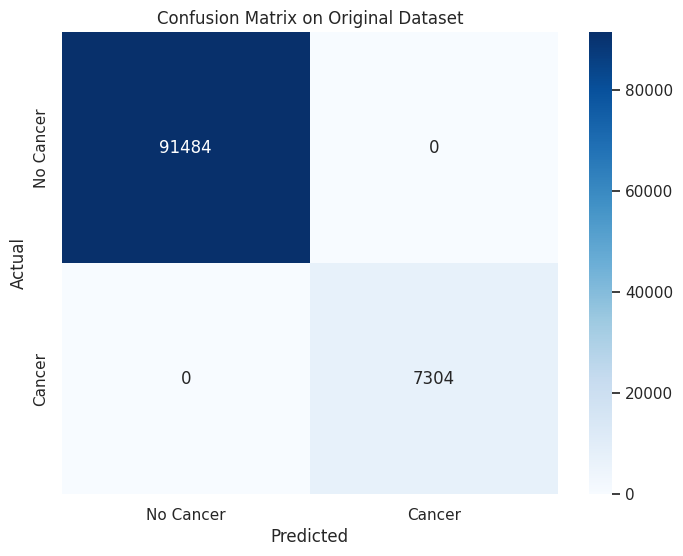

In [12]:
# Step 1: Prepare Original Test Dataset
# Use the original (imbalanced) dataset split into features and target
X_original = df.drop(columns=['cancer_target', 'density_category', 'anon_patientid', 'anon_filename'])
y_original = df['cancer_target']

# Ensure categorical columns are encoded, as done previously
categorical_cols = X_original.select_dtypes(include=['object']).columns
X_original = pd.get_dummies(X_original, columns=categorical_cols, drop_first=True)

# Step 2: Test the Model on Original Dataset
# Use the previously trained Logistic Regression model
y_original_pred = logreg.predict(X_original)
y_original_prob = logreg.predict_proba(X_original)[:, 1]

# Step 3: Evaluate Model Performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

accuracy_original = accuracy_score(y_original, y_original_pred)
precision_original = precision_score(y_original, y_original_pred)
recall_original = recall_score(y_original, y_original_pred)
f1_original = f1_score(y_original, y_original_pred)
roc_auc_original = roc_auc_score(y_original, y_original_prob)

print("Model Performance on Original Dataset:")
print(f"Accuracy: {accuracy_original:.2f}")
print(f"Precision: {precision_original:.2f}")
print(f"Recall: {recall_original:.2f}")
print(f"F1-Score: {f1_original:.2f}")
print(f"AUC-ROC: {roc_auc_original:.2f}")

# Step 4: Confusion Matrix
conf_matrix_original = confusion_matrix(y_original, y_original_pred)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_original, annot=True, fmt="d", cmap="Blues", xticklabels=["No Cancer", "Cancer"], yticklabels=["No Cancer", "Cancer"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Original Dataset")
plt.show()


**RANDOM FOREST MODELLING WITH EXTRACTION OF VITAL FEATURES INVOLVED IN MODELLING**

Random Forest Performance Metrics:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
AUC-ROC: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18297
           1       1.00      1.00      1.00      1461

    accuracy                           1.00     19758
   macro avg       1.00      1.00      1.00     19758
weighted avg       1.00      1.00      1.00     19758



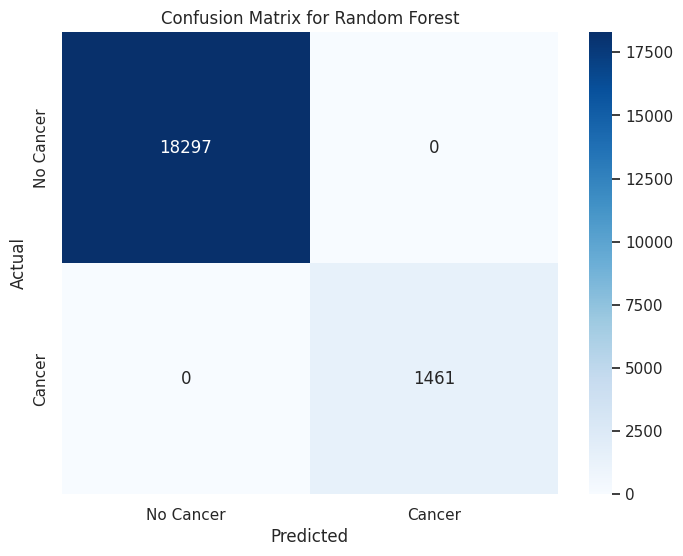


Top 10 Feature Importances:
                      Feature  Importance
2                      x_case    0.623040
20  x_cancer_laterality_Right    0.121302
5                  rad_timing    0.075882
3                      x_type    0.075089
4             x_lymphnode_met    0.033818
19     rad_recall_interaction    0.018297
8                  rad_recall    0.014794
0                   exam_year    0.009366
6                      rad_r1    0.006868
7                      rad_r2    0.006560


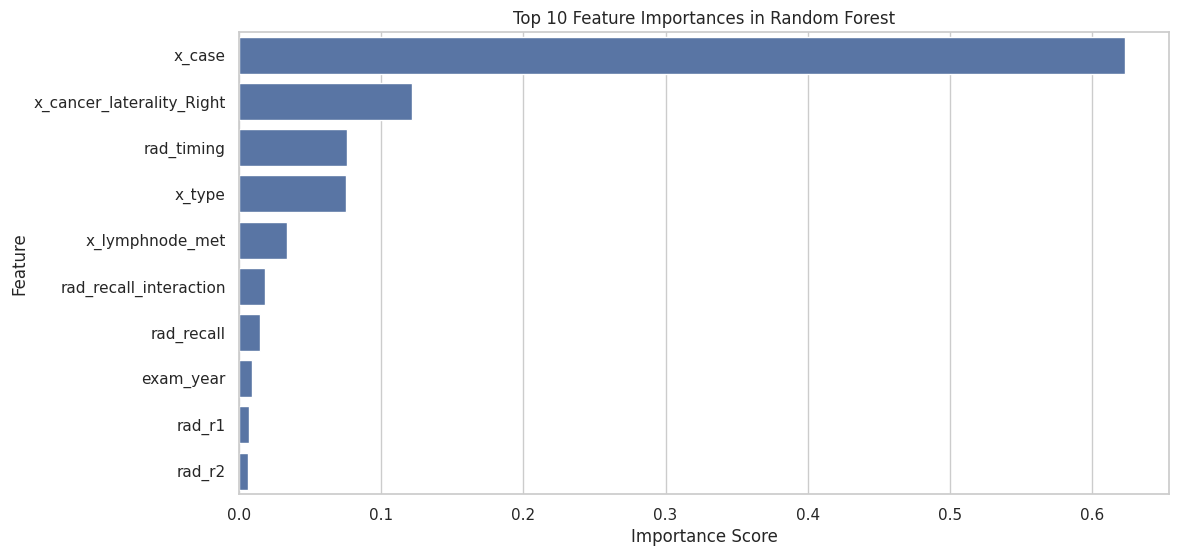

In [13]:


# Step 1: Train-Test Split (Original Dataset)
X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.2, random_state=42, stratify=y_original)

# Step 2: Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")  # Class weight to handle imbalance
rf_model.fit(X_train, y_train)

# Step 3: Make Predictions
y_rf_pred = rf_model.predict(X_test)
y_rf_prob = rf_model.predict_proba(X_test)[:, 1]  # For AUC-ROC

# Step 4: Evaluate Model Performance
accuracy_rf = accuracy_score(y_test, y_rf_pred)
precision_rf = precision_score(y_test, y_rf_pred)
recall_rf = recall_score(y_test, y_rf_pred)
f1_rf = f1_score(y_test, y_rf_pred)
roc_auc_rf = roc_auc_score(y_test, y_rf_prob)

print("Random Forest Performance Metrics:")
print(f"Accuracy: {accuracy_rf:.2f}")
print(f"Precision: {precision_rf:.2f}")
print(f"Recall: {recall_rf:.2f}")
print(f"F1-Score: {f1_rf:.2f}")
print(f"AUC-ROC: {roc_auc_rf:.2f}")

# Step 5: Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_rf_pred))

# Step 6: Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_rf_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["No Cancer", "Cancer"], yticklabels=["No Cancer", "Cancer"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest")
plt.show()

# Step 7: Feature Importance
import pandas as pd

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_importances.head(10))

# Plot Feature Importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Feature Importances in Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


**EXTRACTING & ANALYZING FEATURES FOR OVERFITTING/TARGETED FEATURE LEAKAGE**


Top 10 Feature Importances:
                      Feature  Importance
2                      x_case    0.623040
20  x_cancer_laterality_Right    0.121302
5                  rad_timing    0.075882
3                      x_type    0.075089
4             x_lymphnode_met    0.033818
19     rad_recall_interaction    0.018297
8                  rad_recall    0.014794
0                   exam_year    0.009366
6                      rad_r1    0.006868
7                      rad_r2    0.006560


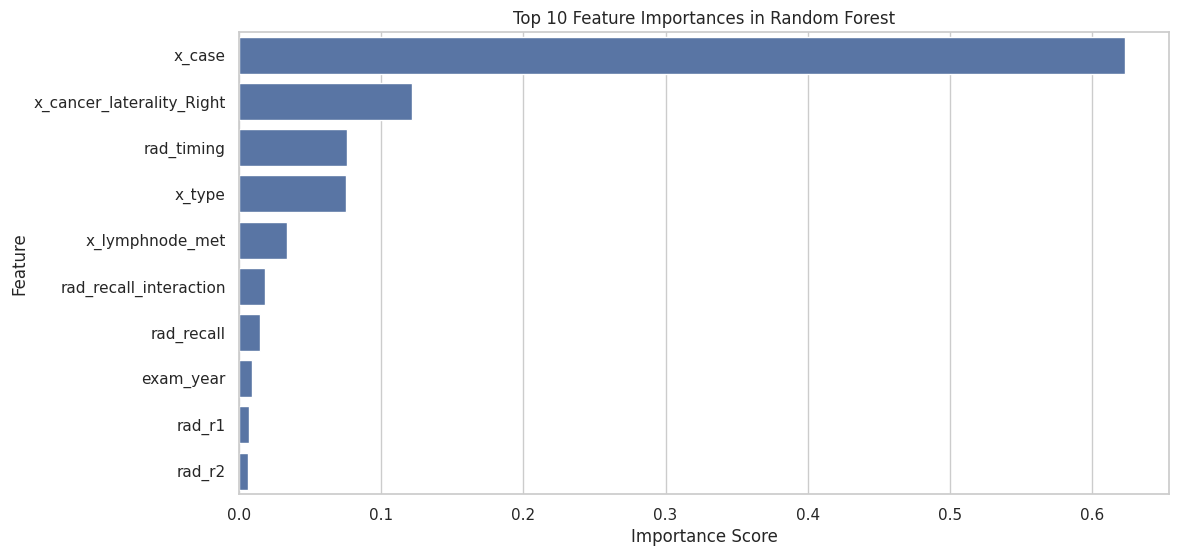

In [14]:
# Analyze Feature Importances


# Extract feature importances from the Random Forest model
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("\nTop 10 Feature Importances:")
print(feature_importances.head(10))

# Plot the feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Feature Importances in Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


**RANDOM FOREST MODELLING AFTER REMOVING LEAKAGE FEATURES**

Random Forest Performance Metrics After Feature Removal:
Accuracy: 0.97
Precision: 0.98
Recall: 0.59
F1-Score: 0.73
AUC-ROC: 0.86


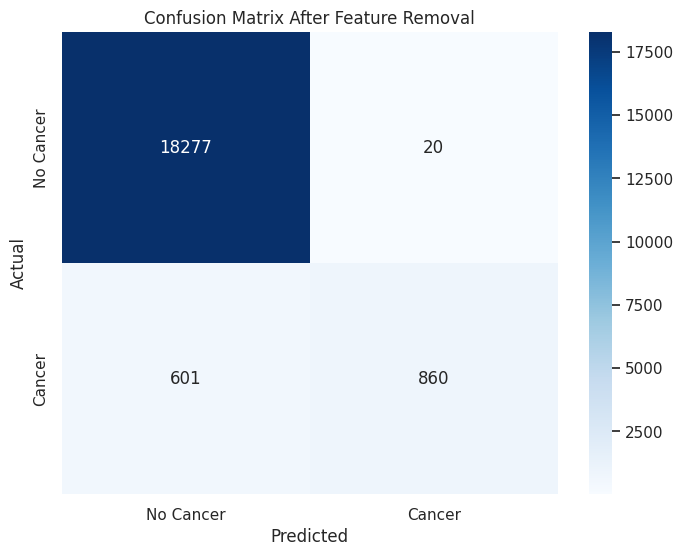


Top 10 Feature Importances After Feature Removal:
                   Feature  Importance
3               rad_timing    0.185749
10         libra_densearea    0.121299
9         libra_breastarea    0.118973
2          x_lymphnode_met    0.116093
11    libra_percentdensity    0.113842
14    breast_density_ratio    0.113752
0                exam_year    0.097287
17  rad_recall_interaction    0.027269
6               rad_recall    0.025292
1                    x_age    0.020228


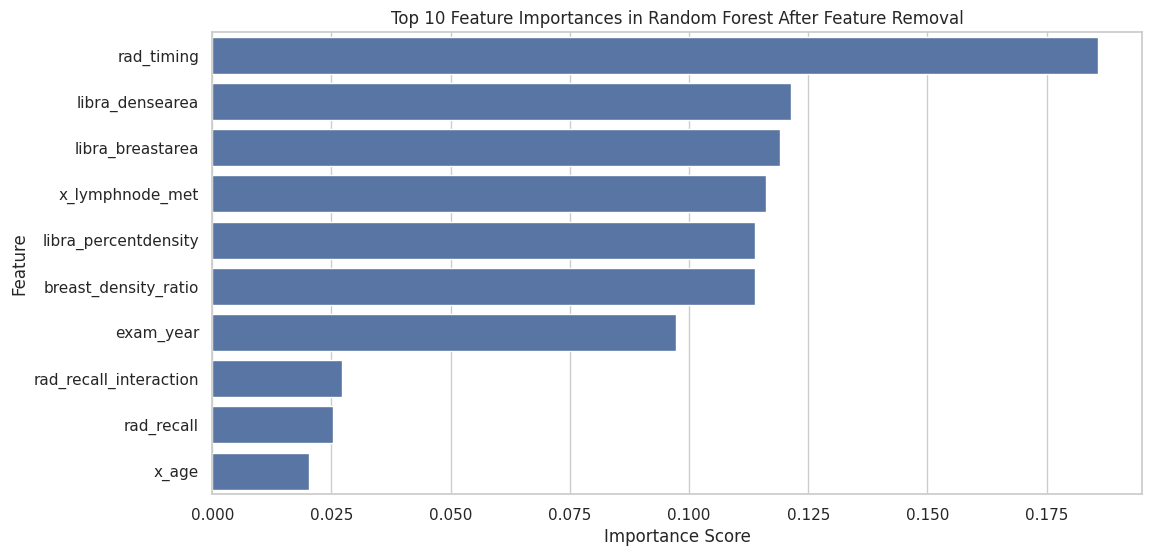

In [15]:
# Step 1: Remove Leakage-Prone Features
leakage_features = ['x_case', 'x_cancer_laterality_Right', 'x_type']
X_filtered = X_original.drop(columns=leakage_features)

# Step 2: Train-Test Split
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, y_original, test_size=0.2, random_state=42, stratify=y_original
)

# Step 3: Train Random Forest Model
rf_model_filtered = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model_filtered.fit(X_train_filtered, y_train_filtered)

# Step 4: Make Predictions
y_rf_filtered_pred = rf_model_filtered.predict(X_test_filtered)
y_rf_filtered_prob = rf_model_filtered.predict_proba(X_test_filtered)[:, 1]

# Step 5: Evaluate Model Performance
accuracy_filtered = accuracy_score(y_test_filtered, y_rf_filtered_pred)
precision_filtered = precision_score(y_test_filtered, y_rf_filtered_pred)
recall_filtered = recall_score(y_test_filtered, y_rf_filtered_pred)
f1_filtered = f1_score(y_test_filtered, y_rf_filtered_pred)
roc_auc_filtered = roc_auc_score(y_test_filtered, y_rf_filtered_prob)

print("Random Forest Performance Metrics After Feature Removal:")
print(f"Accuracy: {accuracy_filtered:.2f}")
print(f"Precision: {precision_filtered:.2f}")
print(f"Recall: {recall_filtered:.2f}")
print(f"F1-Score: {f1_filtered:.2f}")
print(f"AUC-ROC: {roc_auc_filtered:.2f}")

# Step 6: Confusion Matrix
conf_matrix_filtered = confusion_matrix(y_test_filtered, y_rf_filtered_pred)



plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_filtered, annot=True, fmt="d", cmap="Blues", xticklabels=["No Cancer", "Cancer"], yticklabels=["No Cancer", "Cancer"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix After Feature Removal")
plt.show()

# Step 7: Feature Importance After Removing Leakage
feature_importances_filtered = pd.DataFrame({
    'Feature': X_train_filtered.columns,
    'Importance': rf_model_filtered.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Feature Importances After Feature Removal:")
print(feature_importances_filtered.head(10))

# Plot Feature Importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_filtered.head(10))
plt.title('Top 10 Feature Importances in Random Forest After Feature Removal')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


**XGBOOST GRADIENT MODELLING**

Gradient Boosting (XGBoost) Performance Metrics:
Accuracy: 0.88
Precision: 0.35
Recall: 0.74
F1-Score: 0.48
AUC-ROC: 0.90


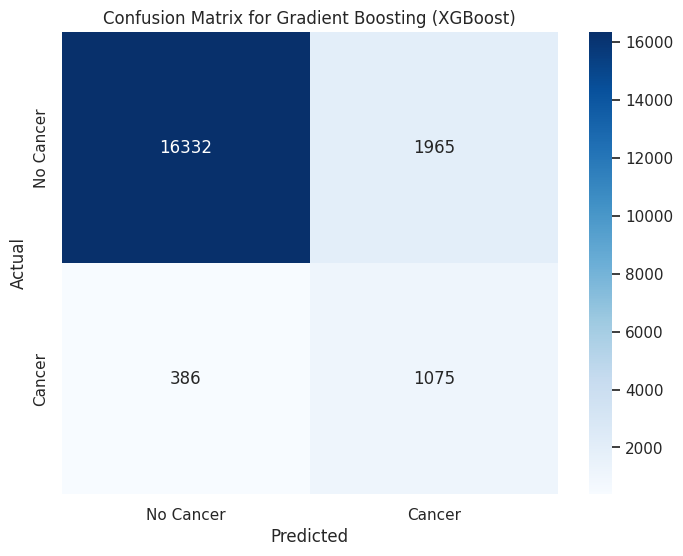


Top 10 Feature Importances in XGBoost:
                  Feature  Importance
3              rad_timing    0.556682
2         x_lymphnode_met    0.259060
0               exam_year    0.058759
1                   x_age    0.027203
5                  rad_r2    0.022196
4                  rad_r1    0.011770
10        libra_densearea    0.009311
16  rad_r1_r2_interaction    0.008361
6              rad_recall    0.007290
7   rad_recall_type_right    0.007041


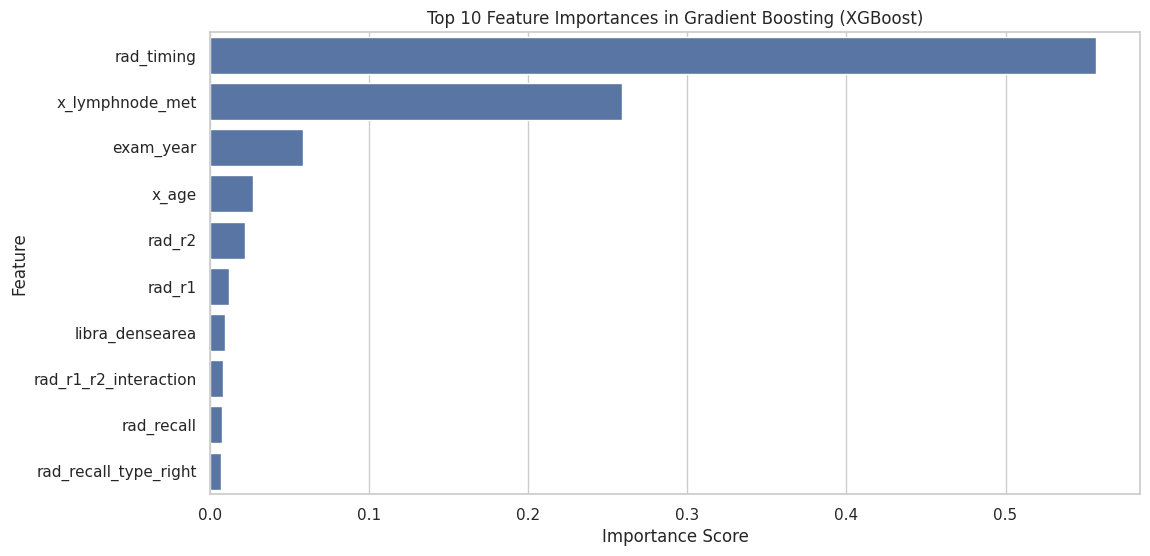

In [ ]:


# Step 1: Train Gradient Boosting Model (XGBoost)
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=len(y_train_filtered[y_train_filtered == 0]) / len(y_train_filtered[y_train_filtered == 1]),  # Handle imbalance
    random_state=42
)

xgb_model.fit(X_train_filtered, y_train_filtered)

# Step 2: Make Predictions
y_xgb_pred = xgb_model.predict(X_test_filtered)
y_xgb_prob = xgb_model.predict_proba(X_test_filtered)[:, 1]  # For AUC-ROC

# Step 3: Evaluate Model Performance
accuracy_xgb = accuracy_score(y_test_filtered, y_xgb_pred)
precision_xgb = precision_score(y_test_filtered, y_xgb_pred)
recall_xgb = recall_score(y_test_filtered, y_xgb_pred)
f1_xgb = f1_score(y_test_filtered, y_xgb_pred)
roc_auc_xgb = roc_auc_score(y_test_filtered, y_xgb_prob)

print("Gradient Boosting (XGBoost) Performance Metrics:")
print(f"Accuracy: {accuracy_xgb:.2f}")
print(f"Precision: {precision_xgb:.2f}")
print(f"Recall: {recall_xgb:.2f}")
print(f"F1-Score: {f1_xgb:.2f}")
print(f"AUC-ROC: {roc_auc_xgb:.2f}")

# Step 4: Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test_filtered, y_xgb_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=["No Cancer", "Cancer"], yticklabels=["No Cancer", "Cancer"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Gradient Boosting (XGBoost)")
plt.show()

# Step 5: Feature Importance
import pandas as pd

feature_importances_xgb = pd.DataFrame({
    'Feature': X_train_filtered.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Feature Importances in XGBoost:")
print(feature_importances_xgb.head(10))

# Plot Feature Importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_xgb.head(10))
plt.title('Top 10 Feature Importances in Gradient Boosting (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


**RANDOM FOREST MODELLING FOR MULTI CLASS CLASSIFICATION**

Categorical Columns: Index(['x_cancer_laterality', 'imagelaterality', 'viewposition',
       'density_category'],
      dtype='object')
Classification Report for Type of Cancer Detection:
              precision    recall  f1-score   support

         1.0       0.42      0.16      0.23       148
         2.0       0.98      0.99      0.99     19020
         3.0       0.61      0.56      0.58       590

    accuracy                           0.97     19758
   macro avg       0.67      0.57      0.60     19758
weighted avg       0.97      0.97      0.97     19758



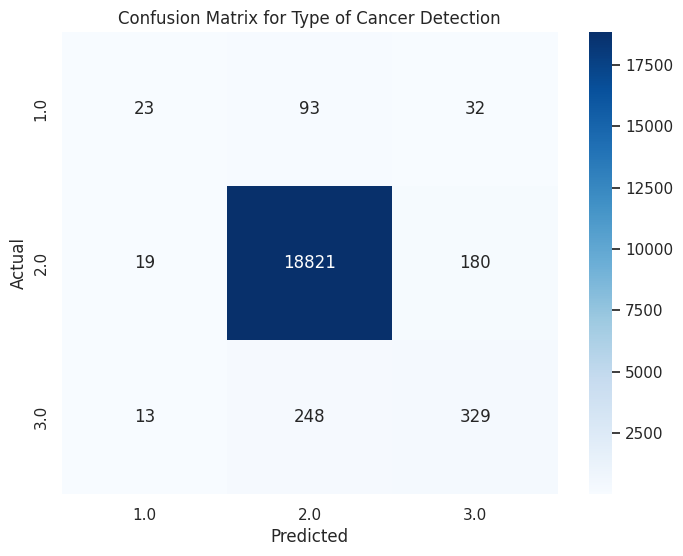


Top 10 Feature Importances for Type of Cancer Detection:
                      Feature  Importance
2                      x_case    0.212714
10           libra_breastarea    0.110359
11            libra_densearea    0.102013
15       breast_density_ratio    0.101268
12       libra_percentdensity    0.099601
3             x_lymphnode_met    0.091788
19  x_cancer_laterality_Right    0.076683
4                  rad_timing    0.059790
0                   exam_year    0.055364
1                       x_age    0.016192


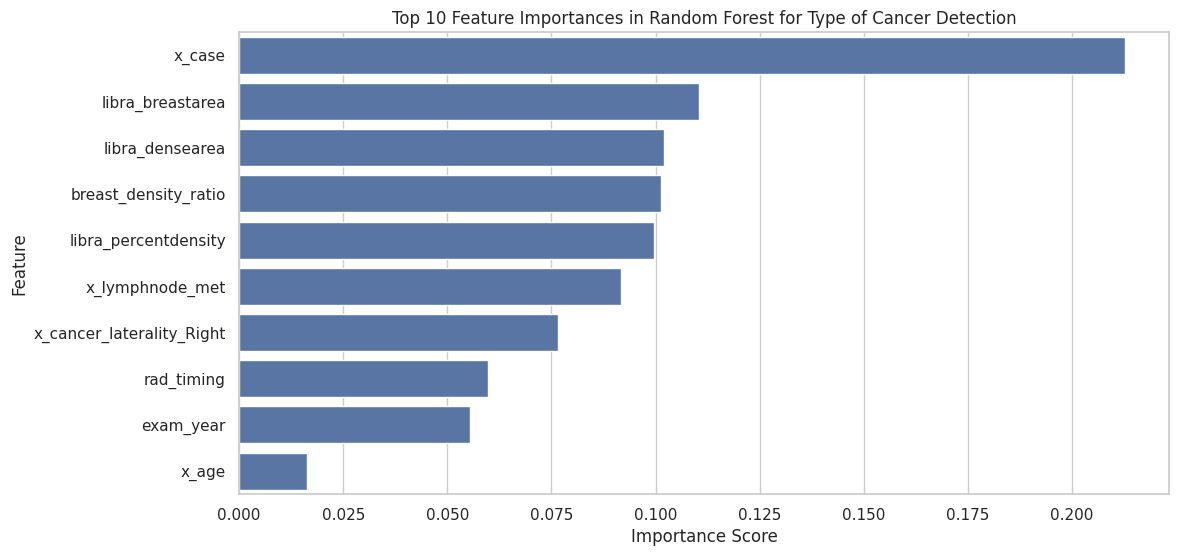

In [ ]:


# Step 1: Prepare the Dataset
# Use x_type as the target and drop it from the features
df = df.dropna(subset=['x_type'])  # Remove rows with missing x_type
X_cancer_type = df.drop(columns=['x_type', 'cancer_target', 'anon_patientid', 'anon_filename'])
y_cancer_type = df['x_type']

# Ensure all categorical columns are encoded
categorical_cols = X_cancer_type.select_dtypes(include=['object', 'category']).columns
print("Categorical Columns:", categorical_cols)

# Use one-hot encoding or label encoding for all categorical features
X_cancer_type = pd.get_dummies(X_cancer_type, columns=categorical_cols, drop_first=True)

# Step 2: Train-Test Split
from sklearn.model_selection import train_test_split
X_train_ct, X_test_ct, y_train_ct, y_test_ct = train_test_split(
    X_cancer_type, y_cancer_type, test_size=0.2, random_state=42, stratify=y_cancer_type
)

# Step 3: Train a Random Forest Model for Multi-Class Classification
rf_cancer_type = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cancer_type.fit(X_train_ct, y_train_ct)

# Step 4: Make Predictions
y_pred_ct = rf_cancer_type.predict(X_test_ct)

# Step 5: Evaluate the Model
print("Classification Report for Type of Cancer Detection:")
print(classification_report(y_test_ct, y_pred_ct))

# Step 6: Confusion Matrix
conf_matrix_ct = confusion_matrix(y_test_ct, y_pred_ct)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ct, annot=True, fmt="d", cmap="Blues", xticklabels=rf_cancer_type.classes_, yticklabels=rf_cancer_type.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Type of Cancer Detection")
plt.show()

# Step 7: Feature Importance
feature_importances_ct = pd.DataFrame({
    'Feature': X_train_ct.columns,
    'Importance': rf_cancer_type.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Feature Importances for Type of Cancer Detection:")
print(feature_importances_ct.head(10))

# Plot Feature Importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_ct.head(10))
plt.title('Top 10 Feature Importances in Random Forest for Type of Cancer Detection')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


**CLASS BALANCING USING SMOTE & RANDOM FOREST MODELLING ON BALANCED DATASET**

Class Distribution After SMOTE:
x_type
2.0    76080
3.0    76080
1.0    76080
Name: count, dtype: int64
Classification Report After Handling Class Imbalance:
              precision    recall  f1-score   support

         1.0       0.23      0.45      0.31       148
         2.0       1.00      0.97      0.98     19020
         3.0       0.47      0.83      0.60       590

    accuracy                           0.96     19758
   macro avg       0.57      0.75      0.63     19758
weighted avg       0.98      0.96      0.97     19758



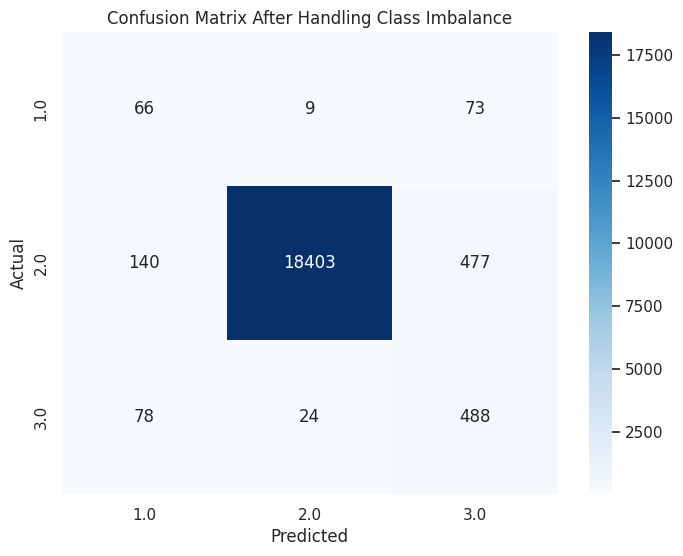

In [ ]:


# Step 1: Apply SMOTE to Handle Class Imbalance
smote = SMOTE(random_state=42)
X_train_ct_balanced, y_train_ct_balanced = smote.fit_resample(X_train_ct, y_train_ct)

# Check the new class distribution
print("Class Distribution After SMOTE:")
print(y_train_ct_balanced.value_counts())

# Step 2: Train a Random Forest Model on Balanced Data
rf_cancer_type_balanced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cancer_type_balanced.fit(X_train_ct_balanced, y_train_ct_balanced)

# Step 3: Make Predictions on the Original Test Set
y_pred_ct_balanced = rf_cancer_type_balanced.predict(X_test_ct)

# Step 4: Evaluate the Model
print("Classification Report After Handling Class Imbalance:")
print(classification_report(y_test_ct, y_pred_ct_balanced))

# Step 5: Confusion Matrix
conf_matrix_ct_balanced = confusion_matrix(y_test_ct, y_pred_ct_balanced)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ct_balanced, annot=True, fmt="d", cmap="Blues", xticklabels=rf_cancer_type.classes_, yticklabels=rf_cancer_type.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix After Handling Class Imbalance")
plt.show()
